<a href="https://colab.research.google.com/github/Sandwhaletree/2023.05_Tibame/blob/main/A12_%E9%80%B2%E9%9A%8E%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92_%E6%9D%8E%E6%99%BA%E6%8F%9A/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
from tqdm.auto import tqdm

In [ ]:
BS = 128
EPOCHS = 10
LOG_INTERVAL = 100 # how many batches to wait before logging training status
device = "cuda" if torch.cuda.is_available() else "cpu"
use_mps = False
kwargs = {'num_workers': 1, 'pin_memory': True}

os.makedirs("results", exist_ok=True) # image dir

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()), # 0~1
    batch_size=BS, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
                   transform=transforms.ToTensor()),
    batch_size=BS, shuffle=False, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 255222291.25it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40217693.83it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 145877183.59it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 21772032.88it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
# 28*28 = 784
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 32),
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.Linear(64, 128),
            nn.Linear(128, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x.view(-1, 784))
        output = self.decoder(z)
        return output

In [ ]:
model = AE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, leave=False)):
        data = data.to(device)
        optimizer.zero_grad()
        img_recon = model(data)
        loss = loss_func(img_recon, data.view(-1, 784))
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            img_recon = model(data)
            test_loss += loss_func(img_recon, data.view(-1, 784)).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      img_recon.view(BS, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/AE_reconstruct_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
# training
for epoch in tqdm(range(1, EPOCHS + 1)):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 32).to(device)
        sample = model.decoder(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/AE_sample_' + str(epoch) + '.png')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.001814
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.000495
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.000320
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.000293
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000252
====> Epoch: 1 Average loss: 0.0004


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


====> Test set loss: 0.0002


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.000247
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.000208
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.000201
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.000201
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.000186
====> Epoch: 2 Average loss: 0.0002


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


====> Test set loss: 0.0002


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.000187

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():


  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.000179
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.000166
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.000162
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.000161
====> Epoch: 3 Average loss: 0.0002


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

====> Test set loss: 0.0002


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.000163


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.000153
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.000146
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000128
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.000129
====> Epoch: 4 Average loss: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

====> Test set loss: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000129


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000135
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000131
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.000131
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000111
====> Epoch: 5 Average loss: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

====> Test set loss: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000120



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib

Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.000110
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.000107
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.000101
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000113
====> Epoch: 6 Average loss: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

====> Test set loss: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000103


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.000109
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000106
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000112
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000102
====> Epoch: 7 Average loss: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

====> Test set loss: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000112


self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessing

Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000099
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.000102
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000103
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000096
====> Epoch: 8 Average loss: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

====> Test set loss: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000095



AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown

Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.000095
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.000095
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000095
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000099
====> Epoch: 9 Average loss: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

====> Test set loss: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/d

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000095


    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>AssertionError
: Traceback (most recent call last):
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.

Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000101
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.000088
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000095
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000095
====> Epoch: 10 Average loss: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9564cd1b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

====> Test set loss: 0.0001


In [ ]:
torch.save(model.state_dict(), "ae.pt")

#### Reconstruct

In [ ]:
import matplotlib.pyplot as plt

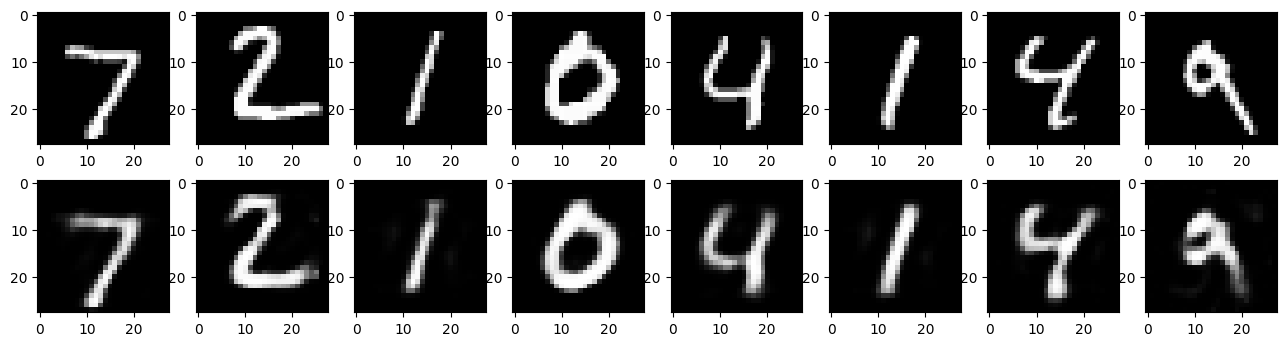

In [ ]:
for i, (data, _) in enumerate(test_loader):
    data = data.to(device)
    img_recon = model(data).view(BS, 1, 28, 28)
    n = min(data.size(0), 8)
    comparison = torch.cat([data[:n],
                          img_recon[:n]]).squeeze(1).detach().cpu()
    # show image
    plt.figure(figsize=(16, 4))
    for i in range(len(comparison)):
        plt.subplot(2, 8, i+1)
        plt.imshow(comparison[i], cmap="gray")
    plt.show()
    break

#### Generative

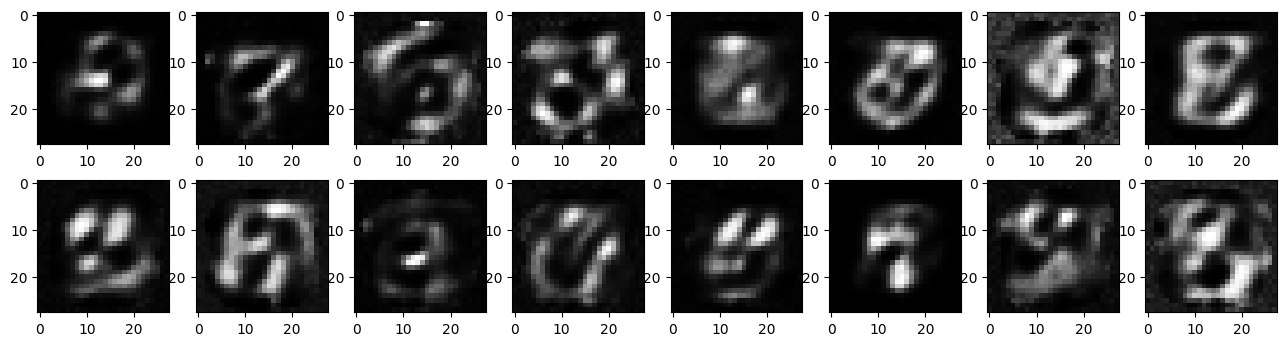

In [ ]:
with torch.no_grad():
    sample = torch.randn(16, 32).to(device)
    sample = model.decoder(sample).reshape(16, 28, 28).cpu()

# show image
plt.figure(figsize=(16, 4))
for i in range(len(sample)):
    plt.subplot(2, 8, i+1)
    plt.imshow(sample[i], cmap="gray")
plt.show()